In [ ]:
#필수 라이브러리

import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.applications as keras_applications


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import cv2



In [ ]:
#파일명까지 path로
data_path = glob('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng/*.jpg')
path = data_path[7]
print(path)

/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng/Snap-0007.jpg


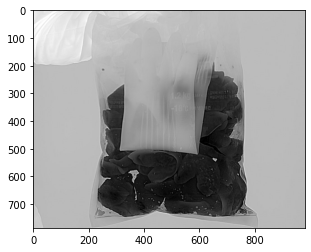

In [ ]:
# 이미지 확인
img_test = cv2.imread(path)
plt.imshow(img_test)

In [ ]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image.shape

TensorShape([786, 982, 3])

In [ ]:
# datagenrator

# datageneratro 생성
datagenerator = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.5, 1.5],
                                  shear_range=0.2,
                                  zoom_range=1.1,
                                  rescale=1./255
                                  )
# 생성한 datagenerator를 image에 적용
image = image[tf.newaxis,...] # 이미지 갯수를 차원을 만들어야 함
image.shape


TensorShape([1, 786, 982, 3])

In [ ]:
image_result = next(iter(datagenerator.flow(image))) # datagenerator에서 설정해준 것들이 하나씩 적용

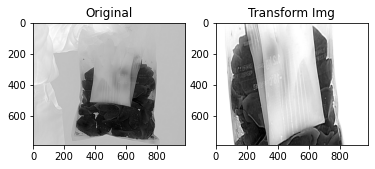

In [ ]:
# 적용된 이미지를 확인해보자

## 원래 이미지
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.squeeze(image), 'gray')
## 왜곡이미지
plt.subplot(1,2,2)
plt.title('Transform Img')
plt.imshow(np.squeeze(image_result), 'gray')

In [ ]:
# 이미지 생성 후 저장
i = 0
for batch in datagenerator.flow(image, batch_size=1,
                                save_to_dir='/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/augmentation', save_prefix='ng_label', save_format='jpg',):
    i +=1
    if i >=20:
        break

# 폴더에 있는 이미지로 학습

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img'
data_path = glob('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng/*.jpg')
path = data_path[1]


gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image.shape

TensorShape([786, 982, 3])

In [ ]:
# input_shape = (786,982,3)
batch_size=32

In [ ]:
# datagenerator 생성
input_shape = (224, 224, 3)
train_datagenerator = ImageDataGenerator(rescale=1./255.,
                                        width_shift_range=0.2,
                                        zoom_range=0.4,
                                        horizontal_flip=True,
                                        )
test_datagenerator = ImageDataGenerator(rescale=1./255.) # 검증,테스트파일은 rescale만

In [ ]:
# 생선된 datagenerator를 이미지에 적용
train_generator = train_datagenerator.flow_from_directory(train_dir,
                                                          target_size = input_shape[:2],
                                                          batch_size = batch_size,
                                                          class_mode='binary',
                                                          classes=['good', 'ng']) # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.

Found 550 images belonging to 2 classes.


In [ ]:
# inputs = Input(input_shape)

# # Convolutional layer
# x = Conv2D(32, (3, 3), activation='relu')(inputs)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# outputs = Dense(1, activation='sigmoid')(x)


# # 모델 생성
# model = Model(inputs=inputs, outputs=outputs)

# # 모델 컴파일
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# model.summary()

In [ ]:
#restnet34
import tensorflow.keras.applications as keras_applications
model = keras_applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(224, 224, 3),
    classes=1
)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# EarlyStopping 콜백 함수 정의
earlystop_callback = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 사용
    min_delta=0.001,  # 0.001보다 작은 개선은 무시
    patience=3  # 3번 이상 개선이 없으면 학습 중지
)

In [ ]:
# 모델 학습
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_freq=.2,
    callbacks=[earlystop_callback]  # EarlyStopping 콜백 함수 전달
)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.8515 - acc: 0.8000

18/18 [==============================] - 49s 661ms/step - loss: 0.8515 - acc: 0.8000
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.5910 - acc: 0.8000

18/18 [==============================] - 13s 686ms/step - loss: 0.5910 - acc: 0.8000
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.3153 - acc: 0.8000

18/18 [==============================] - 13s 679ms/step - loss: 0.3153 - acc: 0.8000
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.2331 - acc: 0.8000

18/18 [==============================] - 12s 669ms/step - loss: 0.2331 - acc: 0.8000
Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 0.2239 - acc: 0.8000

18/18 [==============================] - 13s 678ms/step - loss: 0.2239 - acc: 0.8000
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 0.1829 - acc: 0.8000

18/18 [==============================] - 13s 689ms/step - loss: 0.1829 - acc: 0.8000
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 0.1516 - acc: 0.8000

18/18 [==============================] - 13s 677ms/step - loss: 0.1516 - acc: 0.8000
Epoch 8/10
18/18 [==============================] - ETA: 0s - loss: 0.1179 - acc: 0.8000

18/18 [==============================] - 13s 692ms/step - loss: 0.1179 - acc: 0.8000
Epoch 9/10
18/18 [==============================] - ETA: 0s - loss: 0.1563 - acc: 0.8000

18/18 [==============================] - 13s 680ms/step - loss: 0.1563 - acc: 0.8000
Epoch 10/10
18/18 [==============================] - ETA: 0s - loss: 0.2146 - acc: 0.8000

18/18 [==============================] - 12s 659ms/step - loss: 0.2146 - acc: 0.8000


# 갈비만두 수직